In [1]:
!nvidia-smi


Sun Jul  6 10:43:37 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   31C    P0             44W /  400W |       0MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [2]:
!pip install transformers torch datasets accelerate evaluate scikit-learn wandb
!pip install torch torchvision torchaudio
!pip install imbalanced-learn optuna

Finetuning


In [3]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback
)
from datasets import Dataset as HFDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")

Using device: cuda
GPU: NVIDIA A100-SXM4-40GB
GPU Memory: 39.6 GB


In [4]:

df = pd.read_csv('/dataset/cleaned_sinhala_comments.csv')


In [5]:
df.head()
df.drop(columns=['comment'], inplace=True)


In [6]:

df = df.rename(columns={'cleaned_comment': 'text'})
df.head()

,id,label,text
0,1,0,හුදෙකලා එකේ ද ඇහෙනවද කාටහරි
1,2,0,18ක පෙනුමක් තියෙන්නේ
2,3,0,2020 එනවා කිව්නාට මෙහෙම එයි කියලා හිතුවේ නෑ පට්ට
3,4,0,25 කැල්ලහම්මෝ
4,5,1,25 කෙල්ල අයියලගෙ කාලද කොහෙද ඉන්නෙ


Prepare your dataset

In [7]:
texts = df['text'].tolist()
labels = df['label'].tolist()

# Split the data
X_train, X_temp, y_train, y_temp = train_test_split(
    texts, labels, test_size=0.3, random_state=42, stratify=labels
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print(f"Training set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")
print(f"Test set size: {len(X_test)}")

Training set size: 4441
Validation set size: 952
Test set size: 952


In [8]:
# def prepare_data_enhanced(df, test_size=0.2, val_size=0.2, random_state=42):
#     """Enhanced data preparation with proper stratification"""
#     texts = df['text'].tolist()
#     labels = df['label'].tolist()

#     # First split: train + val vs test
#     X_temp, X_test, y_temp, y_test = train_test_split(
#         texts, labels, test_size=test_size, random_state=random_state, stratify=labels
#     )

#     # Second split: train vs val
#     val_size_adjusted = val_size / (1 - test_size)
#     X_train, X_val, y_train, y_val = train_test_split(
#         X_temp, y_temp, test_size=val_size_adjusted, random_state=random_state, stratify=y_temp
#     )

#     print(f"Training set size: {len(X_train)}")
#     print(f"Validation set size: {len(X_val)}")
#     print(f"Test set size: {len(X_test)}")

#     # Check label distribution in each split
#     print(f"\nTraining set label distribution:")
#     print(pd.Series(y_train).value_counts(normalize=True))
#     print(f"\nValidation set label distribution:")
#     print(pd.Series(y_val).value_counts(normalize=True))
#     print(f"\nTest set label distribution:")
#     print(pd.Series(y_test).value_counts(normalize=True))

#     return X_train, X_val, X_test, y_train, y_val, y_test

# X_train, X_val, X_test, y_train, y_val, y_test = prepare_data_enhanced(df)




In [9]:
model_name = "xlm-roberta-large"

tokenizer = AutoTokenizer.from_pretrained(model_name)
print(f"Tokenizer loaded. Vocab size: {len(tokenizer)}")

Tokenizer loaded. Vocab size: 250002


Using data augmentation to enhance the data

In [10]:
sample_text = "25 ක් වගේ ???ඉතින් වැලලියන්"
tokens = tokenizer(sample_text, return_tensors='pt', padding=True, truncation=True, add_special_tokens=True)
print(f"Sample text: {sample_text}")
print(f"Tokenized: {tokenizer.convert_ids_to_tokens(tokens['input_ids'][0])}")

print(tokens['input_ids'])

Sample text: 25 ක් වගේ ???ඉතින් වැලලියන්
Tokenized: ['<s>', '▁25', '▁ක්', '▁වගේ', '▁???', 'ඉ', 'තින්', '▁වැල', 'ලි', 'යන්', '</s>']
tensor([[     0,    714,   4085,  10407,  37336,  69014, 115678, 192147,   6513,
          10137,      2]])


In [11]:
texts = df['text'].tolist()
lengths = [len(tokenizer.encode(text, add_special_tokens=True)) for text in texts]

print("Max length:", max(lengths))
print("Average length:", np.mean(lengths))
print("95th percentile:", np.percentile(lengths, 95))


Max length: 331
Average length: 26.24381402679275
95th percentile: 82.79999999999927


Token length statistics:
Mean: 27.64
Median: 17.00
95th percentile: 86.00
99th percentile: 177.02
Max: 320


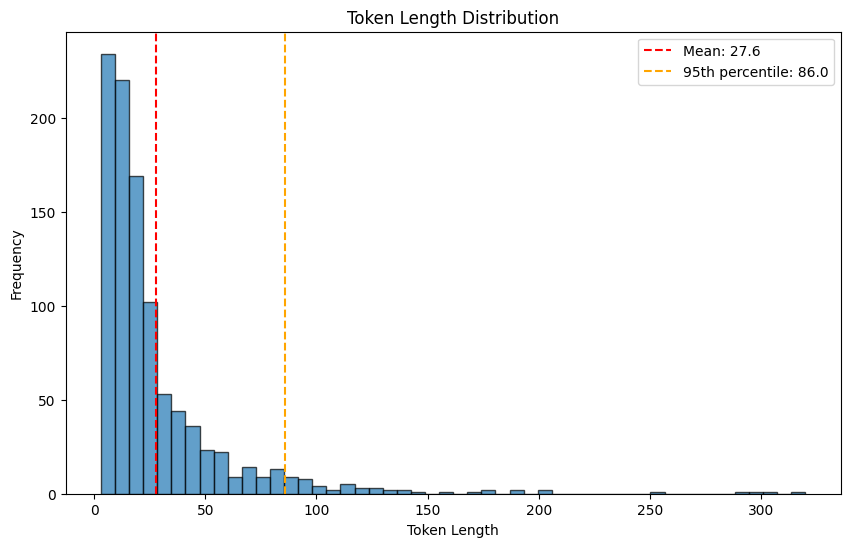


Recommended max_length: 86


In [12]:
def analyze_tokenization(texts, tokenizer, max_samples=1000):
    """Analyze tokenization to determine optimal max_length"""
    sample_texts = texts[:max_samples] if len(texts) > max_samples else texts

    token_lengths = []
    for text in sample_texts:
        tokens = tokenizer(text, truncation=False, padding=False)
        token_lengths.append(len(tokens['input_ids']))

    token_lengths = np.array(token_lengths)

    print(f"Token length statistics:")
    print(f"Mean: {token_lengths.mean():.2f}")
    print(f"Median: {np.median(token_lengths):.2f}")
    print(f"95th percentile: {np.percentile(token_lengths, 95):.2f}")
    print(f"99th percentile: {np.percentile(token_lengths, 99):.2f}")
    print(f"Max: {token_lengths.max()}")

    # Plot distribution
    plt.figure(figsize=(10, 6))
    plt.hist(token_lengths, bins=50, alpha=0.7, edgecolor='black')
    plt.axvline(token_lengths.mean(), color='red', linestyle='--', label=f'Mean: {token_lengths.mean():.1f}')
    plt.axvline(np.percentile(token_lengths, 95), color='orange', linestyle='--', label=f'95th percentile: {np.percentile(token_lengths, 95):.1f}')
    plt.xlabel('Token Length')
    plt.ylabel('Frequency')
    plt.title('Token Length Distribution')
    plt.legend()
    plt.show()

    # Recommend max_length
    recommended_length = min(int(np.percentile(token_lengths, 95)), 512)
    print(f"\nRecommended max_length: {recommended_length}")
    return recommended_length

# Analyze tokenization
MAX_LENGTH = analyze_tokenization(X_train, tokenizer)

In [13]:
class SinhalaDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length, augment= False):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.augment = augment

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        #Simple augmentation fo the training
        if self.augment and np.random.random() < 0.1:
          words = text.split()
          if len(words) > 1:
            mask_idx = np.random.randint(0, len(words))
            words[mask_idx] = '[MASK]'
            text = ' '.join(words)

        encoding = self.tokenizer(
            text,

            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }


In [14]:
train_dataset = SinhalaDataset(X_train, y_train, tokenizer, MAX_LENGTH)
val_dataset = SinhalaDataset(X_val, y_val, tokenizer, MAX_LENGTH)
test_dataset = SinhalaDataset(X_test, y_test, tokenizer, MAX_LENGTH)



In [15]:
num_labels = len(set(labels))
print(num_labels)

2


Load the model

In [16]:
 model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2, problem_type="single_label_classification")
 model.to(device)



Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


XLMRobertaForSequenceClassification(
  (roberta): XLMRobertaModel(
    (embeddings): XLMRobertaEmbeddings(
      (word_embeddings): Embedding(250002, 1024, padding_idx=1)
      (position_embeddings): Embedding(514, 1024, padding_idx=1)
      (token_type_embeddings): Embedding(1, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): XLMRobertaEncoder(
      (layer): ModuleList(
        (0-23): 24 x XLMRobertaLayer(
          (attention): XLMRobertaAttention(
            (self): XLMRobertaSdpaSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): XLMRobertaSelfOutput(
              (dense): Linear(in_features=1024, ou

In [17]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)

    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='weighted')
    acc = accuracy_score(labels, predictions)

    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [18]:
!pip install -U transformers datasets evaluate


In [28]:
training_args = TrainingArguments(
    output_dir='./model',
    num_train_epochs=3,  # Start with 3, increase if needed
    per_device_train_batch_size=32,  # Adjust based on GPU memory
    per_device_eval_batch_size=32,
    warmup_steps=100,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    eval_strategy="steps",
    eval_steps=100,
    save_strategy="steps",
    save_steps=100,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    save_total_limit=2,
    seed=42,
    fp16=True,  # Use mixed precision for faster training
    dataloader_num_workers=4,
    gradient_accumulation_steps=2,  # Effective batch size = 16 * 2 = 32
    learning_rate=2e-5,
    lr_scheduler_type="cosine",
    report_to=None,  # Set to "wandb" if you want to use Weights & Biases
)

In [31]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

In [32]:
print("Training Started ...")
trainer.train()

Training Started ...


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
100,0.140600,0.440528,0.865546,0.865742,0.874278,0.865546
200,0.139800,0.296537,0.894958,0.894996,0.895066,0.894958


TrainOutput(global_step=210, training_loss=0.1725461131050473, metrics={'train_runtime': 106.5695, 'train_samples_per_second': 125.017, 'train_steps_per_second': 1.971, 'total_flos': 2085520417209432.0, 'train_loss': 0.1725461131050473, 'epoch': 3.0})

In [33]:
model.save_pretrained('./fine_tuned_sinhala_model')
tokenizer.save_pretrained('./fine_tuned_sinhala_model')
print("Model saved successfully!")

Model saved successfully!


In [35]:
print("Evaluating on test set...")
test_results = trainer.evaluate(test_dataset)
print("Test Results:")
for key, value in test_results.items():
    print(f"{key}: {value:.4f}")

Evaluating on test set...


Test Results:
eval_loss: 0.3032
eval_accuracy: 0.8960
eval_f1: 0.8960
eval_precision: 0.8961
eval_recall: 0.8960
eval_runtime: 1.4237
eval_samples_per_second: 668.6730
eval_steps_per_second: 21.0720
epoch: 3.0000


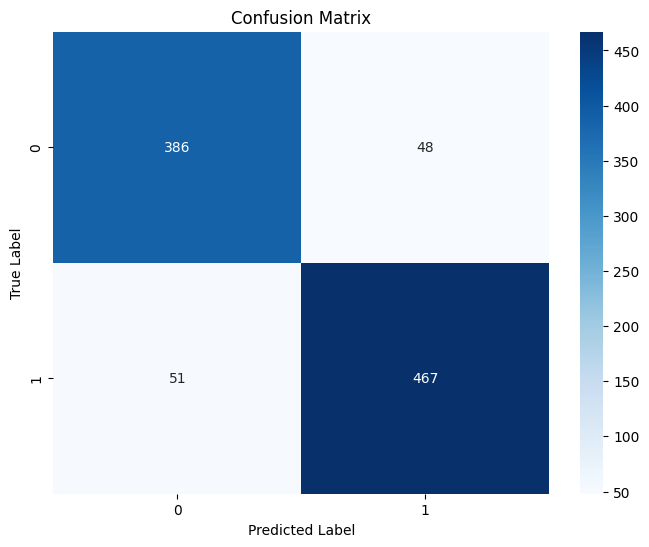


Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.89      0.89       434
           1       0.91      0.90      0.90       518

    accuracy                           0.90       952
   macro avg       0.90      0.90      0.90       952
weighted avg       0.90      0.90      0.90       952



In [36]:
predictions = trainer.predict(test_dataset)
y_pred = np.argmax(predictions.predictions, axis=1)
y_true = y_test

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Classification report
from sklearn.metrics import classification_report
print("\nClassification Report:")
print(classification_report(y_true, y_pred))


In [39]:
print(df[:10])

   id  label                                               text
0   1      0                        හුදෙකලා එකේ ද ඇහෙනවද කාටහරි
1   2      0                               18ක පෙනුමක් තියෙන්නේ
2   3      0   2020 එනවා කිව්නාට මෙහෙම එයි කියලා හිතුවේ නෑ පට්ට
3   4      0                                      25 කැල්ලහම්මෝ
4   5      1                  25 කෙල්ල අයියලගෙ කාලද කොහෙද ඉන්නෙ
5   6      1                        25 ක් වගේ ???ඉතින් වැලලියන්
6   7      0              25 ලුක් එක දැකල ඔලුව සවුත්තු උන තරිදු
7   8      0       25ක පෙනුමක් කියපු කෑල්ලේ ඉදන් බලන එක නතර කලා
8   9      0  33ක් ගුවන්තොටුපළවල ලෝකයේ හිරවෙලා ඉන්නවා ඩුබායි...
9  10      0                          5 දෙනා කිව්වෙ මේ පස්දෙනාද


In [45]:
mixed_texts = [
    "මූගෙ මුහුණ බලන්නෙත් අහිංසක වළලු කෙරෙන්න තමා",                 # 1
    "28ක් වගේ ලු, හැමවිටම සීරියස් mood එකකයි",                      # 0
    "උඹ වගේ ගොන්ජයෙක්ට කොහෙද මෙච්චර හිතෙන හැටි",                   # 1
    "2020 එනවා කිව්නාට මෙහෙම එයි කියලා හිතුවේ නෑ පට්ට",               # 0
    "අර බූරු බයියගේම කතාවක් නේද මේක?",                            # 1
    "25 කැල්ලහම්මෝ",                                                # 0
    "ඇන්ඩා පල, උඹට කතා කරන්නවත් ලැජ්ජාවක් නැද්ද?",                  # 1
    "25 කෙල්ල අයියලගෙ කාලද කොහෙද ඉන්නෙ",                             # 1
    "කියන දේවල් රිදෙන්නත් නැහැ, මෝඩකම ගොඩක් වැඩි",                    # 1
    "25 ක් වගේ ???ඉතින් වැලලියන්",                                   # 1
    "25 ලුක් එක දැකල ඔලුව සවුත්තු උන තරිදු",                          # 0
    "කෙල්ලෝ අස්සෙ හිටගෙන ගොන් සීන් දාන්නෙ නවත්තපං උඹ",                # 1
    "33ක් ගුවන්තොටුපළවල ලෝකයේ හිරවෙලා ඉන්නවා ඩුබායි...",               # 0
    "අනේ මචං, comment එකක් දාන්න කලින් මොළය ගහපං",                     # 1
    "මූ හිතනවද අපි ගොං කියලා? කාලකන්නිලා ටික!",                     # 1
    "විකාර එකෙක්, හැමදාම attention ගන්නයි සෙට් වෙන්නෙ",                  # 1
    "නිකන්ම කියන්නෙ නෑ නේද, මෝඩයෙක් නේද උඹ",                         # 1
    "33ක් වගේ ඇඳලා ඇවිල්ලා, හැබැයි හැඟීම 16යි",                     # 0
    "අර 28 කෙල්ලට නම calling එකේ තියෙන්නේ 'අම්මගෙම ඩෙවි'",              # 1
    "32ත් වුණාම කට්ටියටම කතා කරන්න ඕනෙ කියල හිතෙනව",                   # 0
    "ඔයාට තාම මොළය වැඩ කරන්නේ නැතිද?",                              # 1
    "comment එකක් දාන්නෙත් ටිකක් බුද්ධියෙන් දාපං, ගොන් ගහලා නොබසිලා",      # 1
    "18ක් වගේ තරුණි, ඒත් දරුණු ලොකු වැඩ",                              # 0
    "මූ කියන දේවල් අහලා හිතෙන්නෙ පාටක් පමණයි",                         # 1
    "කියන්නෙ නෑ නෙමෙයි, උඹ වගේ ගොන්ට කවදාවත් තේරෙන්නෙ නෑ",              # 1
    "33ක් වගේම හොඳයි, peaceful vibe එකක් තියෙනවා",                      # 0
    "අර අයියේ status කියවද්දි හිනා වෙනවා නෙමෙයි, ලැජ්ජාවයි",               # 1
    "මූව වගේ පට්ට නරක හැසිරෙන්නෙ බලන්නෙ attention එකට විතරයි",            # 1
]

def predict_text(text, model, tokenizer, device):
    model.eval()
    inputs = tokenizer(
        text,
        return_tensors='pt',
        truncation=True,
        padding=True,
        max_length=128
    ).to(device)

    with torch.no_grad():
        outputs = model(**inputs)
        predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
        predicted_class = torch.argmax(predictions, dim=-1).item()
        confidence = predictions[0][predicted_class].item()

    return predicted_class, confidence

print("\nSample Predictions:")
for text in mixed_texts:
    pred_class, confidence = predict_text(text, model, tokenizer, device)
    print(f"Text: {text}")
    print(f"Predicted class: {pred_class}, Confidence: {confidence:.3f}")
    print("-" * 50)


Sample Predictions:
Text: මූගෙ මුහුණ බලන්නෙත් අහිංසක වළලු කෙරෙන්න තමා
Predicted class: 1, Confidence: 0.996
--------------------------------------------------
Text: 28ක් වගේ ලු, හැමවිටම සීරියස් mood එකකයි
Predicted class: 0, Confidence: 0.980
--------------------------------------------------
Text: උඹ වගේ ගොන්ජයෙක්ට කොහෙද මෙච්චර හිතෙන හැටි
Predicted class: 1, Confidence: 0.990
--------------------------------------------------
Text: 2020 එනවා කිව්නාට මෙහෙම එයි කියලා හිතුවේ නෑ පට්ට
Predicted class: 0, Confidence: 0.976
--------------------------------------------------
Text: අර බූරු බයියගේම කතාවක් නේද මේක?
Predicted class: 1, Confidence: 0.864
--------------------------------------------------
Text: 25 කැල්ලහම්මෝ
Predicted class: 1, Confidence: 0.984
--------------------------------------------------
Text: ඇන්ඩා පල, උඹට කතා කරන්නවත් ලැජ්ජාවක් නැද්ද?
Predicted class: 1, Confidence: 0.997
--------------------------------------------------
Text: 25 කෙල්ල අයියලගෙ කාලද කොහෙද ඉන්නෙ
Predicted

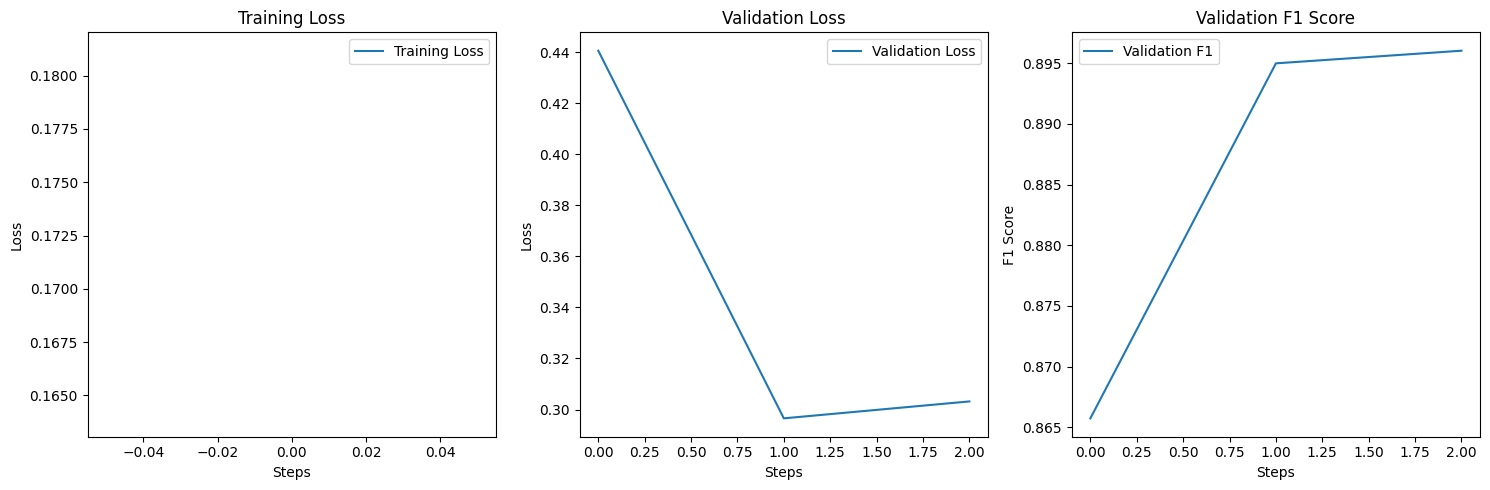

In [46]:
training_history = trainer.state.log_history

train_loss = [log['train_loss'] for log in training_history if 'train_loss' in log]
eval_loss = [log['eval_loss'] for log in training_history if 'eval_loss' in log]
eval_f1 = [log['eval_f1'] for log in training_history if 'eval_f1' in log]

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(train_loss, label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(eval_loss, label='Validation Loss')
plt.title('Validation Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(eval_f1, label='Validation F1')
plt.title('Validation F1 Score')
plt.xlabel('Steps')
plt.ylabel('F1 Score')
plt.legend()

plt.tight_layout()
plt.show()

In [50]:
def load_and_predict_batch(model_path, texts, device='cpu'):
    """
    Load the fine-tuned model and make predictions on a list of texts.
    Returns a list of tuples: (predicted_class, confidence) for each text.
    """
    tokenizer = AutoTokenizer.from_pretrained(model_path)
    model = AutoModelForSequenceClassification.from_pretrained(model_path)
    model.to(device)
    model.eval()

    # Tokenize the batch of texts
    inputs = tokenizer(
        texts,
        return_tensors='pt',
        truncation=True,
        padding=True,
        max_length=90
    ).to(device)

    with torch.no_grad():
        outputs = model(**inputs)
        predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
        predicted_classes = torch.argmax(predictions, dim=-1)

    results = []
    for i in range(len(texts)):
        pred_class = predicted_classes[i].item()
        confidence = predictions[i][pred_class].item()
        results.append((pred_class, confidence))

    return results

# Example usage
texts = [
    "මම සතුටින් ඉන්නවා",
    "උබ මූට වගේ ගොංකමක්, මොළයක් නැති ගොඩක් බකට්ටෙක්!"
]

predictions = load_and_predict_batch('./fine_tuned_sinhala_model', texts)
for text, (pred_class, confidence) in zip(texts, predictions):
    print(f"Text: {text}\nPrediction: {pred_class}, Confidence: {confidence:.3f}\n")

print("\nTraining completed successfully!")
print("Model saved to: ./fine_tuned_sinhala_model")
print("You can now use the model for inference on new Sinhala text!")

Text: මම සතුටින් ඉන්නවා
Prediction: 0, Confidence: 0.996

Text: උබ මූට වගේ ගොංකමක්, මොළයක් නැති ගොඩක් බකට්ටෙක්!
Prediction: 1, Confidence: 0.997


Training completed successfully!
Model saved to: ./fine_tuned_sinhala_model
You can now use the model for inference on new Sinhala text!
